## **Import necessary libraries**

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import os

## **Load data**

In [2]:
path='C:/Users/ASUS/Downloads/FSDKaggle2018/'

# Read metadata file
metadata_file = path + 'FSDKaggle2018.meta/train_post_competition.csv'
# print(metadata_file)
# contents = os.listdir('/content/drive/MyDrive/FSDKaggle2018')

# for item in contents:
#     print(item)
train = pd.read_csv(metadata_file)

# Take relevant columns (features, labels)
train = train[['fname', 'freesound_id', 'label']]
print(train)

# Audio training data path
data_path = path + 'FSDKaggle2018l.audio_train/'


             fname  freesound_id         label
0     00044347.wav         28739        Hi-hat
1     001ca53d.wav        358827     Saxophone
2     002d256b.wav         10897       Trumpet
3     0033e230.wav        325017  Glockenspiel
4     00353774.wav        195688         Cello
...            ...           ...           ...
9468  ffec59fb.wav        343090     Fireworks
9469  fff37590.wav         33136        Hi-hat
9470  fff44ac6.wav        133674      Laughter
9471  fff6a13d.wav         14640         Chime
9472  fff81f55.wav         19117         Cough

[9473 rows x 3 columns]


In [3]:
IMG_SIZE = (128, 128)
TRAIN_PATH = path + 'FSDKaggle2018.audio_train/'
TEST_PATH = path + 'FSDKaggle2018.audio_test/'
batch_size = 64

## **Load datasets**

#### Create custom dataset class

In [4]:
class SoundDataset(Dataset):
    def __init__(self, dataframe, path, test=False):
        super(SoundDataset, self).__init__()
        self.dataframe = dataframe
        self.path = path
        self.test = test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.fname.values[idx]
        label = self.dataframe.label.values[idx]
        path = (TEST_PATH if self.test else TRAIN_PATH) + file_path
        signal, _ = librosa.load(path)
        signal = librosa.feature.melspectrogram(y=signal)
        signal = librosa.power_to_db(signal, ref=np.max)

        try:
            resized = cv2.resize(signal, (IMG_SIZE[1], IMG_SIZE[0]))
        except Exception as e:
            print(path)
            print(str(e))
            resized = np.zeros(shape=(IMG_SIZE[1], IMG_SIZE[0]))

        X = np.stack([resized] * 3)
        X = torch.tensor(X, dtype=torch.float32)

        if not self.test:
            y = label_encoder[label]
            return X, y
        else:
            return X

#### Divide data into datasets

In [5]:
x_train, x_validation, y_train, y_validation = train_test_split(train, train, test_size=0.2, shuffle=True, random_state=5)
train_dataset = SoundDataset(x_train, TRAIN_PATH)
val_dataset = SoundDataset(x_validation, TRAIN_PATH)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
print(x_train.head(), x_train.shape)
print(y_train.head(), y_train.shape)

             fname  freesound_id     label
4882  83953b78.wav        216298   Shatter
4416  77d93f2b.wav         30045  Laughter
4481  79b29f52.wav        176537     Cough
6589  b41d03ad.wav        207124      Bark
1033  1c6b07b8.wav        372776     Cello (7578, 3)
             fname  freesound_id     label
4882  83953b78.wav        216298   Shatter
4416  77d93f2b.wav         30045  Laughter
4481  79b29f52.wav        176537     Cough
6589  b41d03ad.wav        207124      Bark
1033  1c6b07b8.wav        372776     Cello (7578, 3)


In [8]:
labels = np.unique(train.label.values)
label_encoder = {label:i for i, label in enumerate(labels)}

## **Build model**

bug fix

In [9]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

Model structure

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
print(weights)
model = efficientnet_b0(weights=weights)
model.classifier[1] = torch.nn.Linear(1280, 41)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(optimizer)
cost = torch.nn.CrossEntropyLoss()
print(cost)

cpu
EfficientNet_B0_Weights.IMAGENET1K_V1
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


## **Train model**

#### Training loop

In [12]:
# Initialize lists to store training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
def training(epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            loss = cost(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            train_correct += torch.sum(pred.argmax(1) == y).item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = cost(pred, y)
                val_loss += loss.item() * X.size(0)
                val_correct += torch.sum(pred.argmax(1) == y).item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        
        print("Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}".format(epoch+1, train_loss, train_accuracy, val_loss, val_accuracy))
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

#### Train for a number of epochs

In [13]:
num_epochs = 12
training(num_epochs)

Epoch 1, Train Loss: 1.7808, Train Accuracy: 0.5179, Val Loss: 1.1923, Val Accuracy: 0.6617
Epoch 2, Train Loss: 0.8914, Train Accuracy: 0.7392, Val Loss: 0.9842, Val Accuracy: 0.7314
Epoch 3, Train Loss: 0.6078, Train Accuracy: 0.8186, Val Loss: 0.9846, Val Accuracy: 0.7604
Epoch 4, Train Loss: 0.4422, Train Accuracy: 0.8654, Val Loss: 0.9790, Val Accuracy: 0.7694
Epoch 5, Train Loss: 0.3357, Train Accuracy: 0.8959, Val Loss: 0.9912, Val Accuracy: 0.7715
Epoch 6, Train Loss: 0.2835, Train Accuracy: 0.9126, Val Loss: 1.0790, Val Accuracy: 0.7641
Epoch 7, Train Loss: 0.2414, Train Accuracy: 0.9261, Val Loss: 1.0582, Val Accuracy: 0.7726
Epoch 8, Train Loss: 0.1726, Train Accuracy: 0.9479, Val Loss: 1.0892, Val Accuracy: 0.7789
Epoch 9, Train Loss: 0.1695, Train Accuracy: 0.9496, Val Loss: 1.1347, Val Accuracy: 0.7599
Epoch 10, Train Loss: 0.1510, Train Accuracy: 0.9526, Val Loss: 1.1447, Val Accuracy: 0.7736
Epoch 11, Train Loss: 0.1716, Train Accuracy: 0.9475, Val Loss: 1.1662, Val Acc

#### Plot results

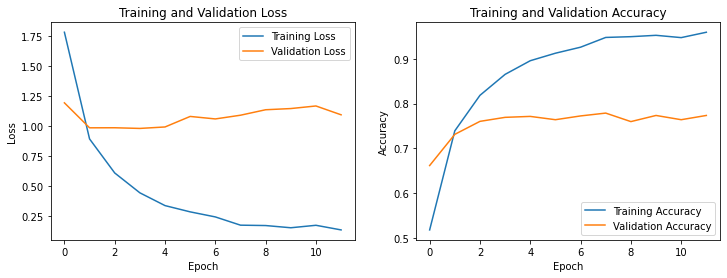

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

## **Evaluate model**

#### Take the testing dataset

In [15]:
testmetadata_file = path + 'FSDKaggle2018.meta/test_post_competition_scoring_clips.csv'
test = pd.read_csv(testmetadata_file)
# Take relevant columns (features, labels)
test = test[['fname', 'freesound_id', 'label']]
print(test)

# Audio training data path
test_data_path = path + 'FSDKaggle2018l.audio_test/'

             fname  freesound_id      label
0     00326aa9.wav        355125       Oboe
1     0038a046.wav         90621  Bass_drum
2     007759c4.wav         13406  Saxophone
3     008afd93.wav        358962  Saxophone
4     00ae03f6.wav         78203      Chime
...            ...           ...        ...
1595  ff96680f.wav        352227       Meow
1596  ffa69cfc.wav         66290  Telephone
1597  ffaca82d.wav        332471   Scissors
1598  ffb6eb52.wav         91139    Cowbell
1599  ffba7963.wav        248994   Clarinet

[1600 rows x 3 columns]


In [16]:
test_dataset = SoundDataset(test, TEST_PATH, test=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions = torch.tensor([])

#### Make predictions

In [17]:
model.eval()
with torch.no_grad():
    for X in test_loader:
        X = X.to(device)
        y_hat = model(X)
        predictions = torch.cat([predictions, y_hat.cpu()])

predictions = F.softmax(predictions, dim=1).detach().numpy()

result = test.copy()

In [18]:
for i in range(len(test)):
    p = predictions[i, :]
    idx = np.argmax(p)
    result.label[i] = labels[idx]

result.to_csv('results.csv', index=False, header=True)

result.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12996\953176731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.label[i] = labels[idx]


,fname,freesound_id,label
0,00326aa9.wav,355125,Oboe
1,0038a046.wav,90621,Bass_drum
2,007759c4.wav,13406,Clarinet
3,008afd93.wav,358962,Saxophone
4,00ae03f6.wav,78203,Chime


#### Evaluate metrics

In [19]:
true_labels = test.label.values
pred_labels = result.label.values

In [20]:
test_label_encoder = LabelEncoder()

In [21]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy}")

# Calculate precision and recall
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the loss score
# Create a label encoder to convert text labels to integers
test_label_encoder = LabelEncoder()
enc_true_labels = test_label_encoder.fit_transform(true_labels)
loss = nn.CrossEntropyLoss()
loss_value = loss(torch.tensor(predictions), torch.tensor(enc_true_labels, dtype=torch.long))
print(f"Logistic Loss: {loss_value.item()}")

Accuracy: 0.825
Precision: 0.833412278152052
Recall: 0.825
Confusion Matrix:
[[ 40   0   0 ...   2   0   0]
 [  0  31   0 ...   0   0   0]
 [  0   0  22 ...   0   0   1]
 ...
 [  0   0   0 ...  30   0   0]
 [  0   0   0 ...   1 107   0]
 [  0   0   0 ...   0   0  19]]
Logistic Loss: 2.9435131549835205


## **Save and load model**

In [22]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

#### Save

In [24]:
# Save the entire model, including the state_dict, optimizer state, and other information
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': cost,
}, 'modelV1.2.pth')


#### Load

In [26]:
# Load the model
checkpoint = torch.load('modelV1.2.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [27]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat